In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.0 MB/s eta 0:00:00


In [3]:
##### Could clean this up a bit

%matplotlib inline

import os
import time
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import cv2

import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision import datasets, models
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torch.utils import data
from torchsummary import summary

from pathlib import Path
from pydicom import dcmread
from tqdm.notebook import tqdm
import skimage.io as sk

from PIL import Image

#torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.1.0+cu121


In [4]:
##### Specify Device

device = torch.device("cpu")

if torch.cuda.is_available():
   print("Training on GPU")
   device = torch.device("cuda:0")


Training on GPU


In [5]:
#Make Labels
df = pd.read_csv("/content/drive/MyDrive/Saliency Map Research 2023/Pneumonia Dataset/Pneumonia_Labels_Final_2.csv")
df2 = df[['Split','patientId','Target']]

df_train = df2.loc[(df2['Split'] == 'train')]
df_train = df_train.drop(df_train.columns[[0]], axis=1)
df_train = df_train.reset_index(drop=True)

df_val = df2.loc[(df2['Split'] == 'val')]
df_val = df_val.drop(df_val.columns[[0]], axis=1)
df_val = df_val.reset_index(drop=True)

df_test = df2.loc[(df2['Split'] == 'test')]
df_test = df_test.drop(df_test.columns[[0]], axis=1)
df_test = df_test.reset_index(drop=True)

#Reduce Size for testing
#train_total = 200
#val_total = 100
#test_total = 0

#df_train = df_train[:train_total]
#df_val = df_val[:val_total]
#df_test = df_test[:test_total]

#Path Split
root = '/content/drive/MyDrive/Saliency Map Research 2023/Pneumonia Dataset/stage_2_train_images_png'

train_labels = df_train[['patientId', 'Target']].to_numpy()
val_labels = df_val[['patientId', 'Target']].to_numpy()
test_labels = df_test[['patientId', 'Target']].to_numpy()

train_paths = [os.path.join(root, image[0]) for image in train_labels]
val_paths = [os.path.join(root, image[0]) for image in val_labels]
test_paths = [os.path.join(root, image[0]) for image in test_labels]

In [7]:
#Make Labels
df = pd.read_csv("/content/drive/MyDrive/Saliency Map Research 2023/Pneumothorax Dataset/Pneumothorax_Labels_Final.csv")
df = df.rename(columns={"label": "Target", "ImageId": "patientId"})
df2 = df[['Split','patientId','Target']]

df_train = df2.loc[(df2['Split'] == 'train')]
df_train = df_train.drop(df_train.columns[[0]], axis=1)
df_train = df_train.reset_index(drop=True)

df_val = df2.loc[(df2['Split'] == 'val')]
df_val = df_val.drop(df_val.columns[[0]], axis=1)
df_val = df_val.reset_index(drop=True)

df_test = df2.loc[(df2['Split'] == 'test')]
df_test = df_test.drop(df_test.columns[[0]], axis=1)
df_test = df_test.reset_index(drop=True)

#Reduce Size for testing
#train_total = 200
#val_total = 100
#test_total = 0

#df_train = df_train[:train_total]
#df_val = df_val[:val_total]
#df_test = df_test[:test_total]

#Path Split
root = '/content/drive/MyDrive/Saliency Map Research 2023/Pneumothorax Dataset/images_png/PNG/train'

train_labels = df_train[['patientId', 'Target']].to_numpy()
val_labels = df_val[['patientId', 'Target']].to_numpy()
test_labels = df_test[['patientId', 'Target']].to_numpy()

train_paths = [os.path.join(root, image[0]) for image in train_labels]
val_paths = [os.path.join(root, image[0]) for image in val_labels]
test_paths = [os.path.join(root, image[0]) for image in test_labels]

In [8]:

#print(f'patientId: {train_labels[0][0]}, Target: {train_labels[0][1]}')
print(len(train_paths))
print(len(val_paths))
print(len(test_paths))

8636
961
1064


In [16]:
#### Transformations
transform_v3 = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(299)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_dense = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

###### READ JPG ######

class PneumoniaDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.annotations = annotation_file
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = (self.annotations.iloc[index, 0] + '.png')
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")
        y_label = torch.tensor(float(self.annotations.iloc[index, 1]))

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [17]:
batch_sz = 16

val_dataset_v3 = PneumoniaDataset(root, df_val, transform=transform_v3)
val_loader_v3 = torch.utils.data.DataLoader(dataset=val_dataset_v3, batch_size=batch_sz, shuffle=False)
test_dataset_v3 = PneumoniaDataset(root, df_test, transform=transform_v3)
test_loader_v3 = torch.utils.data.DataLoader(dataset=test_dataset_v3, batch_size=batch_sz, shuffle=True)

val_dataset_dense = PneumoniaDataset(root, df_val, transform=transform_dense)
val_loader_dense = torch.utils.data.DataLoader(dataset=val_dataset_dense, batch_size=batch_sz, shuffle=False)
test_dataset_dense = PneumoniaDataset(root, df_test, transform=transform_dense)
test_loader_dense = torch.utils.data.DataLoader(dataset=test_dataset_dense, batch_size=batch_sz, shuffle=True)

In [18]:
from sklearn import metrics
from tqdm import tqdm
import torch.nn.functional as nnf

In [19]:
import torch
torch.cuda.empty_cache()

InceptionV3

In [20]:
model = torch.load('/content/drive/MyDrive/Saliency Map Research 2023/Models/thorax_resnet.pt')

In [21]:
model = model.to(device)

In [22]:
from torch.autograd import Variable
from tqdm import tqdm
model.eval()
prob1 = []
results = []
final_targets = []

with torch.no_grad():
  for num, data in enumerate(tqdm(test_loader_dense, desc='Testing')):
    imgs, label = data
    imgs, labels = imgs.to(device), label.to(device)
    test = Variable(imgs)
    output = model(test)
    ps = torch.exp(output)
    prob = nnf.softmax(output, dim=1)
    prob1 += prob.detach().cpu().numpy().tolist()
    top_p, top_class = prob.topk(1, dim=1)
    results += top_class.cpu().numpy().tolist()

    targets = labels.detach().cpu().numpy().tolist()
    final_targets.extend(targets)


Testing: 100%|██████████| 67/67 [12:58<00:00, 11.63s/it]


In [23]:
print(prob1)
prob2 = []
for x in prob1:
  prob2.append(x[1])

print(prob2)

[[0.9999997615814209, 2.3436764706730173e-07], [0.999783456325531, 0.00021653661679010838], [0.9999990463256836, 9.895793482428417e-07], [0.9354329109191895, 0.06456704437732697], [0.9999905824661255, 9.402873729413841e-06], [0.7831671237945557, 0.21683292090892792], [0.12732917070388794, 0.8726708889007568], [0.9999345541000366, 6.545140058733523e-05], [1.0, 1.4625311628435611e-08], [0.9600716829299927, 0.03992827981710434], [0.9554486870765686, 0.04455133527517319], [0.8987711071968079, 0.10122896730899811], [0.9999969005584717, 3.111339083261555e-06], [0.9999998807907104, 8.104305493361608e-08], [1.0, 9.250240851077507e-11], [0.9999992847442627, 6.807283057241875e-07], [0.9977633953094482, 0.002236632164567709], [0.9997246861457825, 0.00027527828933671117], [0.999995231628418, 4.778992661158554e-06], [0.9956710338592529, 0.004328923765569925], [0.9999988079071045, 1.1344736776663922e-06], [0.6083343625068665, 0.39166563749313354], [1.0, 4.408706288927533e-08], [0.9999902248382568, 9

In [24]:
#print(final_targets)
#results = [item for sublist in results for item in sublist]
#print(results)
roc_auc = metrics.roc_auc_score(final_targets, results)
print(roc_auc)

0.6794348508634223


In [25]:
roc_auc = metrics.roc_auc_score(final_targets, prob2)
print(roc_auc)

0.8300914504996137


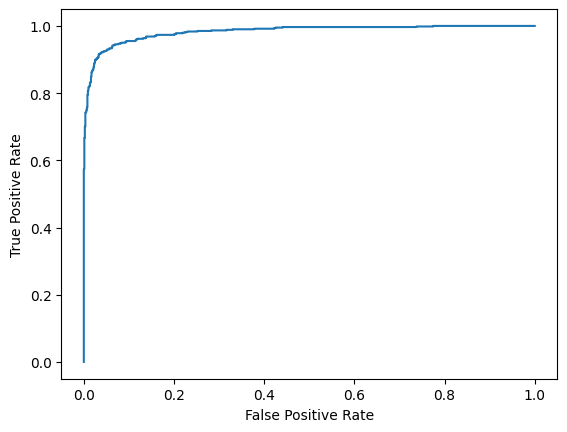

In [ ]:
fpr, tpr, thresh = metrics.roc_curve(final_targets,  prob2, drop_intermediate=False)
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

DenseNet

In [ ]:
model = torch.load('/content/drive/MyDrive/Saliency Map Research 2023/Models/thorax_dense.pt')

In [ ]:
from torch.autograd import Variable
model.eval()
prob1 = []
results = []
final_targets = []
#names = []
print('===============================================start')
for num, data in enumerate(test_loader_v3):
     #print(num)
     #print("=====================================================")

     imgs, label = data
     imgs,labels = imgs.to(device), label.to(device)
     test = Variable(imgs)
     output = model(test)
     #print(output)
     ps = torch.exp(output)
     prob = nnf.softmax(output, dim=1)
     prob1 += prob.detach().cpu().numpy().tolist()
     #print(prob1[:1])
     top_p, top_class = prob.topk(1, dim = 1)
     results += top_class.cpu().numpy().tolist()

     targets = labels.detach().cpu().numpy().tolist()
     final_targets.extend(targets)

print('===============================================end')

===============================================start
===============================================end


In [ ]:
print(prob1)
prob2 = []
for x in prob1:
  prob2.append(x[1])

print(prob2)

[[0.9752933382987976, 0.024706710129976273], [0.9235716462135315, 0.07642841339111328], [0.6891142725944519, 0.3108856976032257], [0.6855801343917847, 0.31441980600357056], [0.1872452348470688, 0.8127548098564148], [0.8730341792106628, 0.12696582078933716], [0.6813402771949768, 0.3186597526073456], [0.8573067784309387, 0.14269323647022247], [0.8110035061836243, 0.18899649381637573], [0.6661525964736938, 0.3338473439216614], [0.8630114197731018, 0.1369885802268982], [0.9774402379989624, 0.02255975268781185], [0.8935607671737671, 0.10643924027681351], [0.3801732063293457, 0.6198267936706543], [0.7629209756851196, 0.23707905411720276], [0.9755997657775879, 0.02440021000802517], [0.5254685878753662, 0.4745313823223114], [0.26472482085227966, 0.735275149345398], [0.64934903383255, 0.3506509065628052], [0.8746669292449951, 0.1253330409526825], [0.96342533826828, 0.036574702709913254], [0.6173000335693359, 0.38269996643066406], [0.9387246966362, 0.06127529218792915], [0.6799679398536682, 0.32

In [ ]:
#print(final_targets)
#results = [item for sublist in results for item in sublist]
#print(results)
roc_auc = metrics.roc_auc_score(final_targets, results)
print(roc_auc)

0.7559855649576903


In [ ]:
roc_auc = metrics.roc_auc_score(final_targets, prob2)
print(roc_auc)

0.8372772523643603


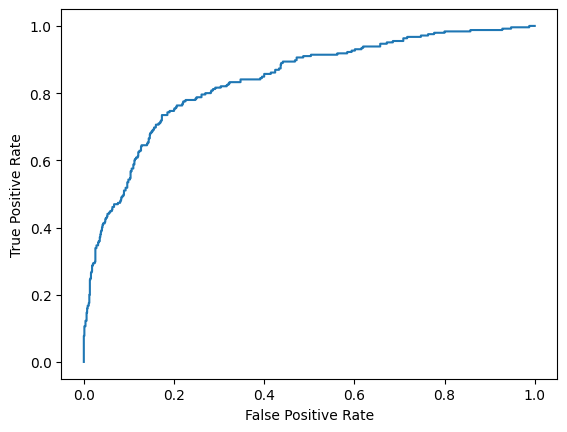

In [ ]:
fpr, tpr, thresh = metrics.roc_curve(final_targets,  prob2, drop_intermediate=False)
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()